In [55]:
import numpy as np
from scipy.integrate import quad
import pyswarms as ps
from pyDOE import lhs
import matplotlib.pyplot as plt


In [56]:
#variables for the problem

ms = 376
mu = 53
ks = 20000 #designVariable x(2)
kt = 170000 #designVariable x(3)
cs = 640 #designVariable x(1)
ct = 0
v = 28
Gd = 0.000016

mass = np.array([ms, mu])
kStiffness = np.array([ks, kt])
cDamping = np.array([cs, ct])


the 'quad' function in scipy returns a multidimensional array, which is not recognised as the objective function in the pyswarms library because of the way it is set up, so we return the first row of quad fn by indexing the first value i.e var[0] 

In [57]:
def psdRoadPert(x, v, Gd):
    return ((Gd)/(2*v))*((x/v)**-2)

def transferFunction(x, mass, cDamping, kStiffness):
    s = 1j*x
    A = s**2*mass[1] + s*np.sum(cDamping) + np.sum(kStiffness)
    B = s*cDamping[1] + kStiffness[1]
    C = s**2*mass[0] + s*cDamping[1] + kStiffness[1]
    D = B
    E = s*cDamping[0] + kStiffness[0]
    value = E*D/(A*C - B*D)
    return np.abs(value)

def psdSprungMassAccel(x, mass, cDamping, kStiffness, v, Gd):
    a = x**4
    b = transferFunction(x, mass, cDamping, kStiffness)
    c = psdRoadPert(x, v, Gd)
    return a*(b**2)*c

def varianceSprungMassAccel(mass, cDamping, kStiffness, v, Gd):
    integFun = lambda x: psdSprungMassAccel(x, mass, cDamping, kStiffness, v, Gd)
    res = quad(integFun, -np.inf, np.inf)
    return res[0]


lhs is a sampling method in a given design space and is used to give the initial spawn points for the particles in PSO evaluation

ravel flattens the array into a vector

In [58]:
lb = np.array([[640, 20000, 170000]])
ub = np.array([[4300, 30000, 260000]])
bounds = (lb.ravel(),ub.ravel())
x0 = lhs(3,1500)
x0 = lb + (ub - lb) * x0

In [59]:
objFunction = lambda x: varianceSprungMassAccel(mass, np.array([ct, x.ravel()[0]]), np.array([x.ravel()[2], x.ravel()[1]]), v, Gd)

options = {'c1': 1.49, 'c2': 1.49, 'w':0.5}
pso = ps.single.GlobalBestPSO(n_particles=x0.shape[0], dimensions=3, options=options, bounds=bounds, init_pos=x0)

cost, pos = pso.optimize(objFunction, iters=1000)


2022-08-21 17:04:34,232 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 1.49, 'c2': 1.49, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=4.58
2022-08-21 17:04:47,744 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.57851538939396, best pos: [  4186.6357761   22878.21593784 206893.01031079]


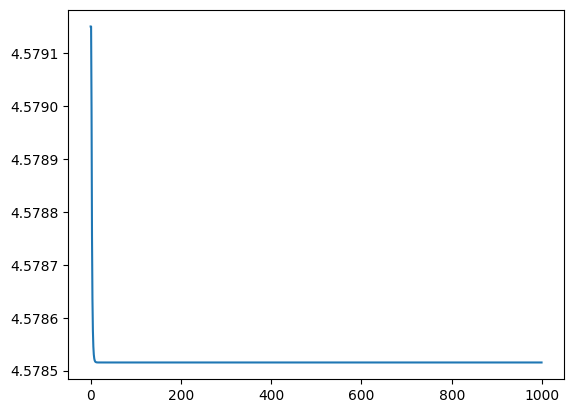

In [60]:
history = pso.cost_history
plt.plot(history)
plt.show()